In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.extremes import Peaks_Over_Threshold as POT
from teslakit.util.time_operations import xds_reindex_daily

from teslakit.mda import MaxDiss_Simplified_NoThreshold



C:\Users\lcag075\AppData\Local\Continuum\anaconda2\envs\teslakit\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# --------------------------------------
# Teslakit database

p_data = r'C:\Users\lcag075\Dropbox\MAJURO-teslakit\teslakit\DATA'
db = Database(p_data)

# set site
db.SetSite('MAJURO')

# MDA number of cases
num_sel_mda = 500

In [16]:
# --------------------------------------
# Load complete hourly data for extremes analysis

# Historical
# WVS = db.Load_WAVES_hist()

CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
# Simulation

HS=[]; H1=[]; H2=[]; H3=[]
TS=[]; T1=[]; T2=[]; T3=[]
DS=[]; D1=[]; D2=[]; D3=[]
MSL=[]; WD=[]; WS=[]
for a in range (5):
    WVS_sim, tc_sim, WVS_upd1 = CE.LoadSim(n_sim = a)
    HS=np.append(HS,WVS_sim.sea_Hs); H1=np.append(H1,WVS_sim.swell_1_Hs); H2=np.append(H2,WVS_sim.swell_2_Hs); H3=np.append(H3,WVS_sim.swell_3_Hs)
    TS=np.append(TS,WVS_sim.sea_Tp); T1=np.append(T1,WVS_sim.swell_1_Tp); T2=np.append(T2,WVS_sim.swell_2_Tp); T3=np.append(T3,WVS_sim.swell_3_Tp);
    DS=np.append(DS,WVS_sim.sea_Dir); D1=np.append(D1,WVS_sim.swell_1_Dir); D2=np.append(D2,WVS_sim.swell_2_Dir); D3=np.append(D3,WVS_sim.swell_3_Dir);
    MSL=np.append(MSL, WVS_sim.msl); WD=np.append(WD,WVS_sim.wind_dir);  WS=np.append(WS,WVS_sim.wind_speed); 

In [17]:
# --------------------------------------
# MaxDiss classification

# subset, scalar and directional indexes
data_mda = np.column_stack((HS,H1,H2,H3,TS,T1,T2,T3,DS,D1,D2,D3,MSL,WD,WS))
ix_scalar = [0,1,2,3,4,5,6,7,12,13,14]
ix_directional = [8,9,10,11]


In [18]:
# MDA
centroids = MaxDiss_Simplified_NoThreshold(
    data_mda, num_sel_mda, ix_scalar, ix_directional 
)



MaxDiss waves parameters: 425893 --> 500

   MDA centroids: 500/500



In [19]:
# store MDA storms - parameters 
MDA_params = xr.Dataset(
    {
        'sea_Hs':(('storm'), centroids[:,0]),
        'swell_1_Hs':(('storm'), centroids[:,1]),
        'swell_2_Hs':(('storm'), centroids[:,2]),
        'swell_3_Hs':(('storm'), centroids[:,3]),
        'sea_Tp':(('storm'), centroids[:,4]),
        'swell_1_Tp':(('storm'), centroids[:,5]),
        'swell_2_Tp':(('storm'), centroids[:,6]),
        'swell_3_Tp':(('storm'), centroids[:,7]),
        'sea_Dir':(('storm'), centroids[:,8]),
        'swell_1_Dir':(('storm'), centroids[:,9]),
        'swell_2_Dir':(('storm'), centroids[:,10]),
        'swell_3_Dir':(('storm'), centroids[:,11]),
        'msl':(('storm'), centroids[:,12]),
        'wdir':(('storm'), centroids[:,13]),
        'wspeed':(('storm'), centroids[:,14]),
        
    },
    coords = {
        'storm':(('storm'), np.arange(num_sel_mda))    
    },
)

MDA_params.to_netcdf(op.join(p_data, 'sites' ,'MAJURO','MDA_Selection_500_3000yearsmaxstorm.nc'))

In [66]:
HIST_C_h = db.Load_HIST_OFFSHORE(decode_times=True)

In [67]:
HIST_C_h=HIST_C_h.drop(('AWT','MJO','AT','AWL','level','max_storms','swell_1_Dir','swell_2_Dir','swell_3_Dir','swell_1_Hs','swell_2_Hs','swell_3_Hs','swell_1_Tp','swell_2_Tp','swell_3_Tp','DWT','MMSL','sea_Hs','sea_Tp','sea_Dir','TWL'))

In [68]:
press=xr.open_dataset(op.join(p_data, 'sites' ,'MAJURO', 'WIND_PRESSURE','Pressures.nc'))
wind=xr.open_dataset(op.join(p_data, 'sites' ,'MAJURO', 'WIND_PRESSURE','Winds.nc'))
# resample extra data
WDS = wind.resample(time='1h').pad()
PSS = press.resample(time='1h').pad()

In [69]:
WDS=WDS.drop(('longitude','latitude','U','V'))

In [70]:
WDS['wdir']=(['time'], WDS.Dir.values)

In [73]:
WDS=WDS.drop('Dir')

In [75]:
HIST_C_h.update(WDS)

<xarray.Dataset>
Dimensions:  (time: 427320)
Coordinates:
  * time     (time) object 1970-06-01 00:00:00 ... 2019-02-28 23:00:00
Data variables:
    Dir      (time) float64 ...
    Hs       (time) float64 ...
    Tp       (time) float64 ...
    Speed    (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    wdir     (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [76]:
HIST_C_h.update(PSS)

<xarray.Dataset>
Dimensions:    (time: 427320)
Coordinates:
  * time       (time) object 1970-06-01 00:00:00 ... 2019-02-28 23:00:00
    longitude  float32 171.25
    latitude   float32 7.25
Data variables:
    Dir        (time) float64 ...
    Hs         (time) float64 ...
    Tp         (time) float64 ...
    Speed      (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    wdir       (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    msl        (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [77]:
del WDS, PSS

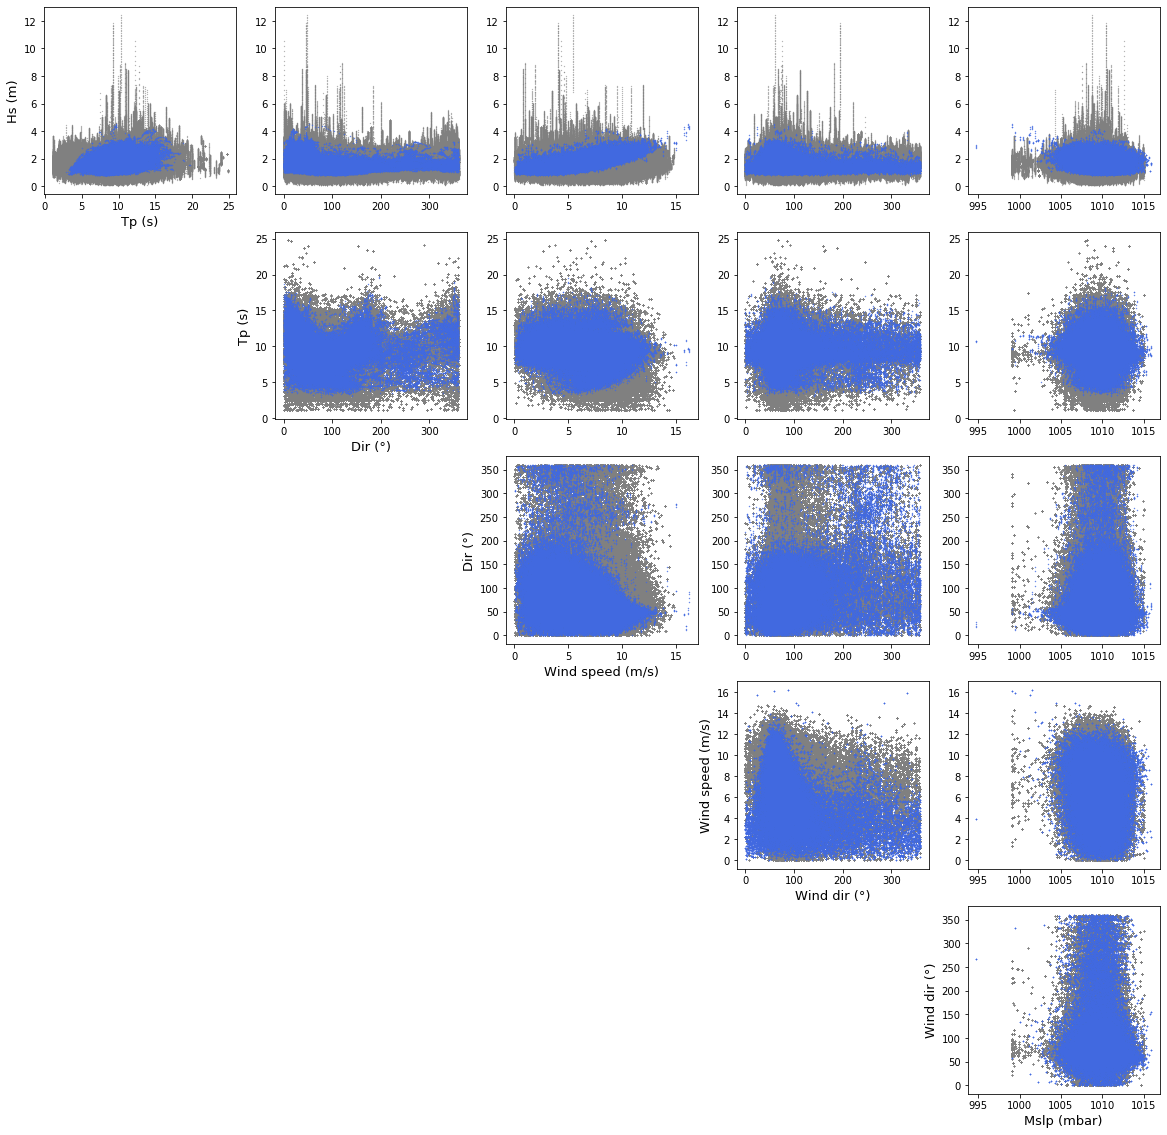

In [78]:
pts_sim_size=0.5
color_sim='grey'

pts_mda_size=0.8
color_mda='royalblue'

fig = plt.figure(figsize=[20,20])
gs2=gridspec.GridSpec(5,5)

ax0=fig.add_subplot(gs2[0])
ax0.plot(data_mda[:10000000,1],data_mda[:10000000,0],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.Tp,HIST_C_h.Hs,'.',markersize=pts_mda_size,color=color_mda)
ax0.set_xlabel('Tp (s)',fontsize=13)
ax0.set_ylabel('Hs (m)',fontsize=13)
ax0=fig.add_subplot(gs2[1])
ax0.plot(data_mda[:10000000,2],data_mda[:10000000,0],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.Dir,HIST_C_h.Hs,'.',markersize=pts_mda_size,color=color_mda)
ax0=fig.add_subplot(gs2[2])
ax0.plot(data_mda[:10000000,3],data_mda[:10000000,0],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.Speed,HIST_C_h.Hs,'.',markersize=pts_mda_size,color=color_mda)
ax0=fig.add_subplot(gs2[3])
ax0.plot(data_mda[:10000000,4],data_mda[:10000000,0],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.wdir,HIST_C_h.Hs,'.',markersize=pts_mda_size,color=color_mda)
ax0=fig.add_subplot(gs2[4])
ax0.plot(data_mda[:10000000,5]/100,data_mda[:10000000,0],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.msl/100,HIST_C_h.Hs,'.',markersize=pts_mda_size,color=color_mda)

ax0=fig.add_subplot(gs2[6])
ax0.plot(data_mda[:10000000,2],data_mda[:10000000,1],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.Dir,HIST_C_h.Tp,'.',markersize=pts_mda_size,color=color_mda)
ax0.set_xlabel('Dir (°)',fontsize=13)
ax0.set_ylabel('Tp (s)',fontsize=13)
ax0=fig.add_subplot(gs2[7])
ax0.plot(data_mda[:10000000,3],data_mda[:10000000,1],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.Speed,HIST_C_h.Tp,'.',markersize=pts_mda_size,color=color_mda)
ax0=fig.add_subplot(gs2[8])
ax0.plot(data_mda[:10000000,4],data_mda[:10000000,1],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.wdir,HIST_C_h.Tp,'.',markersize=pts_mda_size,color=color_mda)
ax0=fig.add_subplot(gs2[9])
ax0.plot(data_mda[:10000000,5]/100,data_mda[:10000000,1],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.msl/100,HIST_C_h.Tp,'.',markersize=pts_mda_size,color=color_mda)

ax0=fig.add_subplot(gs2[12])
ax0.plot(data_mda[:10000000,3],data_mda[:10000000,2],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.Speed,HIST_C_h.Dir,'.',markersize=pts_mda_size,color=color_mda)
ax0.set_xlabel('Wind speed (m/s)',fontsize=13)
ax0.set_ylabel('Dir (°)',fontsize=13)
ax0=fig.add_subplot(gs2[13])
ax0.plot(data_mda[:10000000,4],data_mda[:10000000,2],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.wdir,HIST_C_h.Dir,'.',markersize=pts_mda_size,color=color_mda)
ax0=fig.add_subplot(gs2[14])
ax0.plot(data_mda[:10000000,5]/100,data_mda[:10000000,2],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.msl/100,HIST_C_h.Dir,'.',markersize=pts_mda_size,color=color_mda)

ax0=fig.add_subplot(gs2[18])
ax0.plot(data_mda[:10000000,4],data_mda[:10000000,3],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.wdir,HIST_C_h.Speed,'.',markersize=pts_mda_size,color=color_mda)
ax0.set_xlabel('Wind dir (°)',fontsize=13)
ax0.set_ylabel('Wind speed (m/s)',fontsize=13)
ax0=fig.add_subplot(gs2[19])
ax0.plot(data_mda[:10000000,5]/100,data_mda[:10000000,3],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.msl/100,HIST_C_h.Speed,'.',markersize=pts_mda_size,color=color_mda)


ax0=fig.add_subplot(gs2[24])
ax0.plot(data_mda[:10000000,5]/100,data_mda[:10000000,4],'.',markersize=pts_sim_size,color=color_sim)
ax0.plot(HIST_C_h.msl/100,HIST_C_h.wdir,'.',markersize=pts_mda_size,color=color_mda)
ax0.set_ylabel('Wind dir (°)',fontsize=13)
ax0.set_xlabel('Mslp (mbar)',fontsize=13)

plt.show()